In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

 95% 315M/331M [00:04<00:00, 29.4MB/s]
100% 331M/331M [00:04<00:00, 83.0MB/s]


In [ ]:
!unzip -qq utkface-new.zip

In [22]:
!pip install wandb

In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers , models , Sequential , optimizers ,applications

import cv2
import matplotlib.pyplot as plt
import wandb
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)



In [24]:
run = wandb.init(project="Age_Prediction")
config = wandb.config
wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

wandb: Currently logged in as: mohamad-nematizadehhh. Use `wandb login --relogin` to force relogin


In [3]:
width = height = 100

In [4]:
imags = [] #X
ages = []  #Y
for image_name in os.listdir("UTKFace"):
  parts = image_name.split("_")
  age = int(parts[0])
  ages.append(age)

  image = cv2.imread("UTKFace/"+image_name)
  image = cv2.resize(image,(width,height))
  image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
  imags.append(image)

In [5]:
imags = pd.Series(imags, name="Images")
ages = pd.Series(ages , name="Ages")
df = pd.concat([imags,ages],axis=1)
df.head()

,Images,Ages
0,"[[[3, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], ...",30
1,"[[[177, 177, 177], [178, 178, 178], [179, 179,...",9
2,"[[[180, 160, 133], [196, 176, 149], [170, 149,...",39
3,"[[[18, 7, 11], [18, 7, 11], [17, 8, 11], [15, ...",35
4,"[[[174, 163, 141], [171, 160, 138], [162, 151,...",83


70


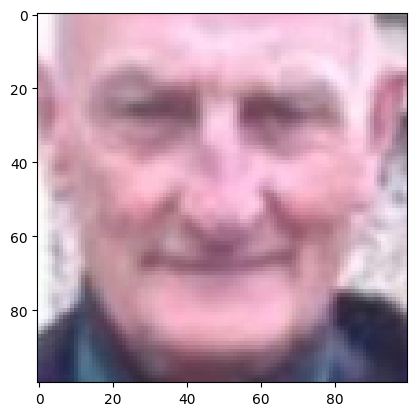

In [6]:
print(df["Ages"][67])
plt.imshow(df["Images"][67])
plt.show()

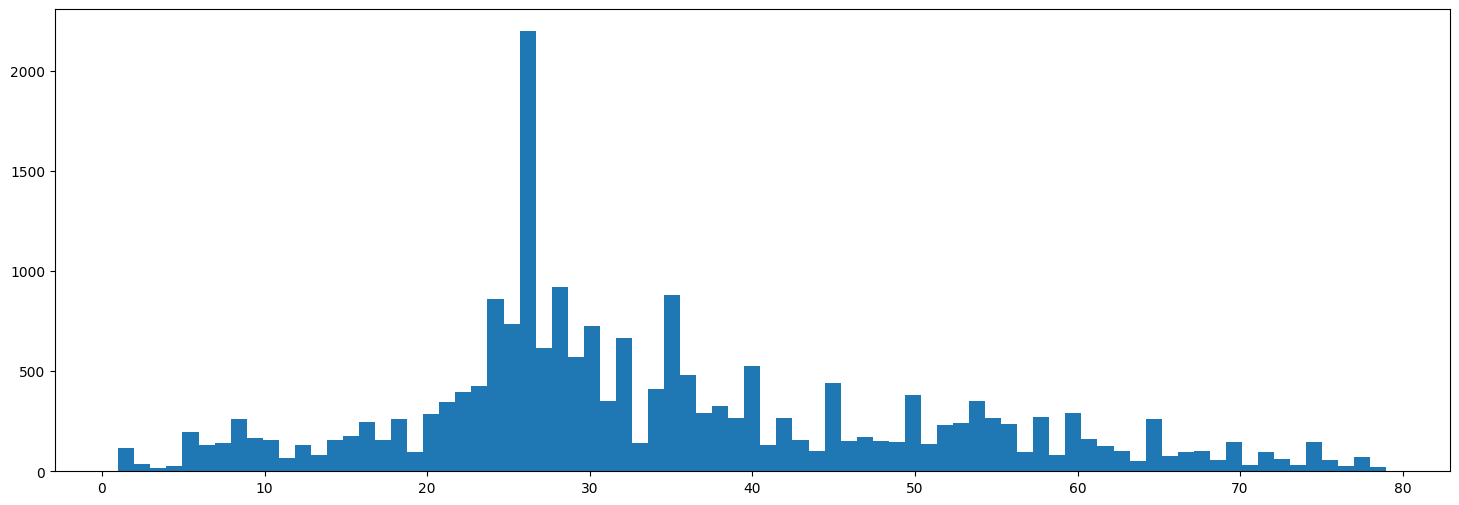

In [11]:
plt.figure(figsize=(18,6))
plt.hist(df["Ages"],bins=df["Ages"].max())
plt.show()

In [8]:
under_4 = df[df["Ages"] <= 4]
up_4 = df[df["Ages"] > 4]
under_4 = under_4.sample(frac=0.3)
df = pd.concat([under_4,up_4] , axis=0)
df = df[df["Ages"] < 80]

In [9]:
X = np.array(df["Images"].values.tolist())
Y = np.array(df["Ages"].values.tolist())


In [10]:
X.shape

(21063, 100, 100, 3)

In [12]:
X_train,X_validation , Y_train , Y_validation = train_test_split(X,Y,test_size=0.2)
print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(16850, 100, 100, 3)
(4213, 100, 100, 3)
(16850,)
(4213,)


In [13]:
image_data_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,

)
train_data = image_data_generator.flow(
    X_train,
    Y_train,
    batch_size=32,
    shuffle=True
)

validation_data = image_data_generator.flow(
    X_validation,
    Y_validation,
    batch_size=32,
    shuffle=True
)

Creat Model


In [16]:
base_model = applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(width,height,3),
    pooling="avg"
)

94668760/94668760 [==============================] - 5s 0us/step


In [17]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [18]:
my_model = Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.Dense(1,activation='relu'),
])


In [20]:
from keras.src.saving.legacy.saving_utils import losses
my_model.compile(
    loss = losses.mean_absolute_error,
    optimizer=optimizers.Adam(learning_rate=0.01)
)

In [25]:
plt_model = my_model.fit(train_data, validation_data=validation_data,callbacks=wandb_callbacks, epochs=20)

Epoch 1/20
527/527 [==============================] - ETA: 0s - loss: 9.2773

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 42s 79ms/step - loss: 9.2773 - val_loss: 8.8631
Epoch 2/20
526/527 [============================>.] - ETA: 0s - loss: 9.2487

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 44s 84ms/step - loss: 9.2482 - val_loss: 8.9690
Epoch 3/20
527/527 [==============================] - ETA: 0s - loss: 9.3296

wandb: Adding directory to artifact (./models)... Done. 0.4s


527/527 [==============================] - 43s 81ms/step - loss: 9.3296 - val_loss: 8.8615
Epoch 4/20
527/527 [==============================] - ETA: 0s - loss: 9.2600

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 41s 78ms/step - loss: 9.2600 - val_loss: 8.8121
Epoch 5/20
526/527 [============================>.] - ETA: 0s - loss: 9.3090

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 47s 89ms/step - loss: 9.3064 - val_loss: 8.7801
Epoch 6/20
526/527 [============================>.] - ETA: 0s - loss: 9.2915

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 43s 82ms/step - loss: 9.2929 - val_loss: 8.7076
Epoch 7/20
526/527 [============================>.] - ETA: 0s - loss: 9.2718

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 44s 83ms/step - loss: 9.2710 - val_loss: 8.6629
Epoch 8/20
526/527 [============================>.] - ETA: 0s - loss: 9.2113

wandb: Adding directory to artifact (./models)... Done. 0.4s


527/527 [==============================] - 43s 82ms/step - loss: 9.2150 - val_loss: 8.8068
Epoch 9/20
526/527 [============================>.] - ETA: 0s - loss: 9.2216

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 43s 81ms/step - loss: 9.2208 - val_loss: 8.7235
Epoch 10/20
527/527 [==============================] - ETA: 0s - loss: 9.2451

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 42s 80ms/step - loss: 9.2451 - val_loss: 8.6998
Epoch 11/20
526/527 [============================>.] - ETA: 0s - loss: 9.2356

wandb: Adding directory to artifact (./models)... Done. 0.4s


527/527 [==============================] - 43s 82ms/step - loss: 9.2397 - val_loss: 8.6888
Epoch 12/20
527/527 [==============================] - ETA: 0s - loss: 9.2582

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 42s 80ms/step - loss: 9.2582 - val_loss: 8.7192
Epoch 13/20
526/527 [============================>.] - ETA: 0s - loss: 9.2593

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 42s 80ms/step - loss: 9.2613 - val_loss: 8.6502
Epoch 14/20
526/527 [============================>.] - ETA: 0s - loss: 9.2756

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 43s 81ms/step - loss: 9.2723 - val_loss: 8.9323
Epoch 15/20
526/527 [============================>.] - ETA: 0s - loss: 9.1640

wandb: Adding directory to artifact (./models)... Done. 0.4s


527/527 [==============================] - 43s 82ms/step - loss: 9.1628 - val_loss: 8.7025
Epoch 16/20
526/527 [============================>.] - ETA: 0s - loss: 9.2343

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 42s 79ms/step - loss: 9.2385 - val_loss: 8.7780
Epoch 17/20
527/527 [==============================] - ETA: 0s - loss: 9.2224

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 42s 80ms/step - loss: 9.2224 - val_loss: 8.7521
Epoch 18/20
527/527 [==============================] - ETA: 0s - loss: 9.1809

wandb: Adding directory to artifact (./models)... Done. 0.4s


527/527 [==============================] - 43s 81ms/step - loss: 9.1809 - val_loss: 8.7153
Epoch 19/20
527/527 [==============================] - ETA: 0s - loss: 9.2359

wandb: Adding directory to artifact (./models)... Done. 0.5s


527/527 [==============================] - 44s 83ms/step - loss: 9.2359 - val_loss: 8.6750
Epoch 20/20
527/527 [==============================] - ETA: 0s - loss: 9.2271

wandb: Adding directory to artifact (./models)... Done. 0.3s


527/527 [==============================] - 44s 84ms/step - loss: 9.2271 - val_loss: 8.7625


1/1 [==============================] - 0s 25ms/step
[[16.81992]]


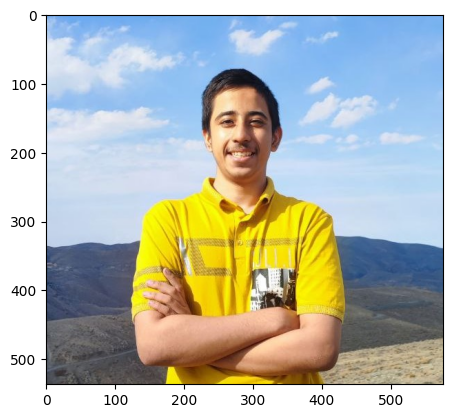

In [33]:
image = cv2.imread("/content/6.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
image = cv2.resize(image,(width,height))
image = image / 255.0
image = image[np.newaxis, ...]

result = my_model.predict(image)
print(result)
plt.show()